## **Proyecto - Base de datos de Big Data**

Óscar Nava Jiménez
A01745524

## **Descripción de la Base de datos**

Base de datos seleccionada: IBM Transactions for Anti-Money Laundering (AML), versión LI-Medium

La base de datos está compuesta por aproximadamente 31 millones de transacciones, contiene una menor proporción de casos positivos de lavado de dinero respecto a las otras versiones.

Se cuenta con información como: momento de la transacción, bancos y cuentas involucradas, montos ($) y monedas, formato y si la transacción se considera o no lavado de dinero.

# **Cargando el entorno de PySpark en Google Colab**

In [1]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q http://archive.apache.org/dist/spark/spark-3.1.1/spark-3.1.1-bin-hadoop3.2.tgz
!tar xf spark-3.1.1-bin-hadoop3.2.tgz
!pip install -q findspark

E: Could not open lock file /var/lib/dpkg/lock-frontend - open (13: Permission denied)
E: Unable to acquire the dpkg frontend lock (/var/lib/dpkg/lock-frontend), are you root?


In [2]:
!ls

LI-Medium_Trans.csv	  spark-3.1.1-bin-hadoop3.2	 work
Metricas_A01745524.ipynb  spark-3.1.1-bin-hadoop3.2.tgz


In [3]:
import findspark
findspark.init()
findspark.find()

from pyspark import SparkContext, SparkConf, SQLContext
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").config("spark.driver.memory", "16g").config("spark.executor.memory", "32g").getOrCreate()
spark.conf.set("sparl.sql.repl.eagerEval.enabled", True)
spark

In [4]:
import numpy as np
import pandas as pd
from pyspark.sql.functions import count, when, isnan, col
import matplotlib.pyplot as plt
import seaborn as sns
from pyspark.sql.functions import mean, stddev, min, max

In [5]:
df = spark.read.csv("LI-Medium_Trans.csv",
                    header=True, sep=",", inferSchema=True)

# **1. Construcción de la muestra M**
## **Selección de los Datos**

In [6]:
# Se tomarán los datos únicamente de América con métodos de pago clásicos para reducir la cantidad de información a procesar
Payment_Format_Classic = ["Credit Card","Cheque","Cash","Reinvestment"]
Payment_Currency_America = ["Mexican Peso", "US Dollar", "Brazil Real", "Canadian Dollar"]


# Payment Format = Classic y Payment Currency = America
# Partción M1 nombrada como df_part
df_part = df.filter((col("Payment Format").isin(Payment_Format_Classic)) & (col("Payment Currency").isin(Payment_Currency_America)))
print("Partición: Classic y America")

# Una vez realizada la partición M1 se tomara un muestreo aleatorio del 50% de datos resultantes para el procesamiento posterior
df_part = df_part.sample(0.5,0)
df_part.show()

Partición: Classic y America
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+
|2022/09/01 00:23|     1208|80010E430|   1208|80010E430|        2654.22|         US Dollar|    2654.22|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:19|     3203|80010EA80|   3203|80010EA80|       13284.41|         US Dollar|   13284.41|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:29|       20|800104D70|     20|800104D70|           5.38|         US Dollar|       5.38|       US Dollar|  Reinvestment|            0|
|2022/09/01 00:08|     1208|80010E430|   1208|80010E430|           7.66

In [7]:
print("Numero de elementos: ",df_part.count())
df_part.describe()

Numero de elementos:  6053079


DataFrame[summary: string, Timestamp: string, From Bank: string, Account2: string, To Bank: string, Account4: string, Amount Received: string, Receiving Currency: string, Amount Paid: string, Payment Currency: string, Payment Format: string, Is Laundering: string]

In [8]:
df = df_part


# **Preparación de los Datos**

In [9]:
import pyspark.sql.functions as F
# Imprimiendo el esquema del Dataframe
df.printSchema()

root
 |-- Timestamp: string (nullable = true)
 |-- From Bank: integer (nullable = true)
 |-- Account2: string (nullable = true)
 |-- To Bank: integer (nullable = true)
 |-- Account4: string (nullable = true)
 |-- Amount Received: double (nullable = true)
 |-- Receiving Currency: string (nullable = true)
 |-- Amount Paid: double (nullable = true)
 |-- Payment Currency: string (nullable = true)
 |-- Payment Format: string (nullable = true)
 |-- Is Laundering: integer (nullable = true)



In [10]:
# Imprimiendo datos nulos
display(df.select([count(when(col(c).isNull(), c)).alias(c) for c in df.columns]))

DataFrame[Timestamp: bigint, From Bank: bigint, Account2: bigint, To Bank: bigint, Account4: bigint, Amount Received: bigint, Receiving Currency: bigint, Amount Paid: bigint, Payment Currency: bigint, Payment Format: bigint, Is Laundering: bigint]

In [11]:
# Distribución de lavado de dinero
df_temp = df.groupby('Is Laundering').count()
display(df_temp.withColumn('percent', (df_temp['count']/df.count()) * 100))

DataFrame[Is Laundering: int, count: bigint, percent: double]

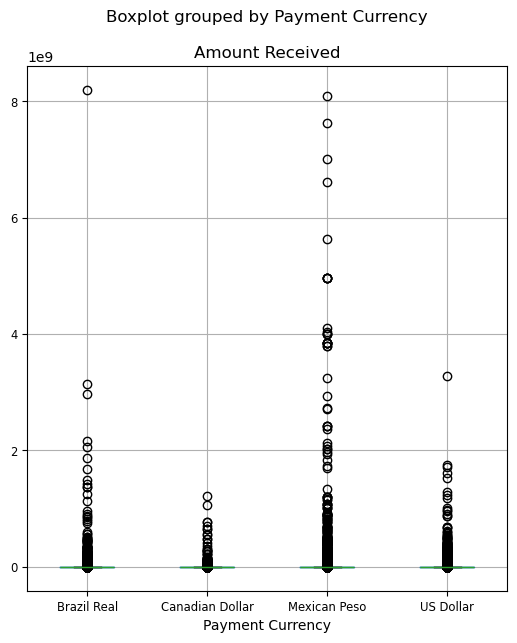

In [48]:
df_temp = df.toPandas()
# Boxplot de cantidades de dinero recibidas por divisa
plot = df_temp.boxplot(column='Amount Received', by='Payment Currency', fontsize='small', figsize=(6,7))

In [12]:
# Codificador One-Hot para la variable Payment Format
from pyspark.ml.feature import StringIndexer, OneHotEncoder
stringIndexer = StringIndexer(inputCol="Payment Format", outputCol="payment_format_index")
model = stringIndexer.fit(df)
indexed = model.transform(df)
encoder = OneHotEncoder(dropLast=False, inputCol="payment_format_index", outputCol="payment_format_vec")
encoder = encoder.fit(indexed)
encoded = encoder.transform(indexed)
df = encoded

# Codificador One-Hot para la variable Currency
stringIndexer = StringIndexer(inputCol="Payment Currency", outputCol="payment_currency_index")
model = stringIndexer.fit(df)
indexed = model.transform(df)
encoder = OneHotEncoder(dropLast=False, inputCol="payment_currency_index", outputCol="payment_currency_vec")
encoder = encoder.fit(indexed)
encoded = encoder.transform(indexed)
df = encoded

In [13]:
# Función para determinar si la transacción fue realizad entre un mismo banco
df = df.withColumn('is_same_bank', (F.col('From Bank') == F.col('To Bank')).cast('integer'))

In [15]:
# Balanceo de clases puesto que la cantidad de fraudes es muy reducida
minority_df = df.filter(col('Is Laundering') == 1)
majority_df = df.filter(col('Is Laundering') == 0)

oversampled_minority_df = minority_df.sample(withReplacement=True, fraction=20.0, seed=42)
df  = majority_df.union(oversampled_minority_df)


# **2. Construcción Train – Test**
## **Preparación del Conjunto de Entrenamiento y Prueba**

Como se menciona en el reporte "Why 70/30 or 80/20 Relation Between Training and Testing Sets: A Pedagogical Explanation" de la Universidad de Texas (2018) al realizar ajustes de modelos a partir de datos, para evitar el sobreajuste, es importante dividir los datos en el conjunto de entrenamiento y el conjunto de prueba. Primero se entrena el modelo con el conjunto de entrenamiento y luego usamos los datos del conjunto de prueba para evaluar la precisión del modelo resultante. Estudios empíricos demuestran que los mejores resultados se obtienen si utilizamos entre el 20 % y el 30 % de los datos para las pruebas y el 70 % u 80 % restante para el entrenamiento.

Fuente: https://scholarworks.utep.edu/cs_techrep/1209/#:~:text=We%20first%20train%20our%20model,of%20the%20data%20for%20training.

In [16]:
# Separación de conjuntos de datos de entrenamiento y de pruebas
train_data, test_data = df.randomSplit([0.7, .3])

# **3. Selección de métricas para medir calidad de resultados**

Se seleccionó la métrica ROC para calificar el modelo de regresión logística puesto que ROC AUC (Área Bajo la Curva ROC) es especialmente importante en problemas de clasificación, incluyendo aquellos en los que se utiliza regresión logística. Esto se debe a que la regresión logística produce probabilidades de pertenencia a una clase, no etiquetas directamente y ROC AUC mide qué tan bien el modelo separa las clases positivas de las negativas.La interpretación de esta métrica consiste en la probabilidad de que el modelo asigne una probabilidad más alta a una instancia positiva que a una negativa elegida al azar.

# **4. Entrenamiento de Modelos de Aprendizaje**

## **Supervisado: Regresión Logística**

In [17]:
from pyspark.ml.feature import StringIndexer, VectorAssembler, OneHotEncoder, StandardScaler
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml import Pipeline

In [18]:
assembler = VectorAssembler(inputCols=['payment_format_vec',
                                       'payment_currency_vec','Amount Received','is_same_bank'],
                                    outputCol='features')
# Escalamiento de la columna features
scaler = StandardScaler(inputCol="features", outputCol="scaled_features")

In [19]:
log_reg = LogisticRegression(featuresCol='scaled_features',
                             labelCol='Is Laundering')

# Creación de la pipeline
pipeline = Pipeline(stages=[assembler, scaler, log_reg])

fit_model = pipeline.fit(train_data)

# Almacenamiento y muestra de resultados
results = fit_model.transform(test_data)
results.show()

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+--------------------+------------------+----------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|payment_format_index|payment_format_vec|payment_currency_index|payment_currency_vec|is_same_bank|            features|     scaled_features|       rawPrediction|         probability|prediction|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+--------------------+------------------+----------------------+--------------------+------------+--------------------+--------------------+--------------------+-------

In [20]:
# Evaluador
from pyspark.ml.evaluation import BinaryClassificationEvaluator

# Calling the evaluator
res = BinaryClassificationEvaluator(rawPredictionCol='prediction',labelCol='Is Laundering')

# Evaluating the AUC on results
ROC_AUC = res.evaluate(results)

In [21]:
# Evaluador
predictions = fit_model.transform(test_data)
predictions.show()
evaluator = MulticlassClassificationEvaluator(labelCol="Is Laundering", predictionCol="prediction", metricName="accuracy")
accuracy = evaluator.evaluate(predictions)

print(f"Test Accuracy: {accuracy:.2f}")

+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+--------------------+------------------+----------------------+--------------------+------------+--------------------+--------------------+--------------------+--------------------+----------+
|       Timestamp|From Bank| Account2|To Bank| Account4|Amount Received|Receiving Currency|Amount Paid|Payment Currency|Payment Format|Is Laundering|payment_format_index|payment_format_vec|payment_currency_index|payment_currency_vec|is_same_bank|            features|     scaled_features|       rawPrediction|         probability|prediction|
+----------------+---------+---------+-------+---------+---------------+------------------+-----------+----------------+--------------+-------------+--------------------+------------------+----------------------+--------------------+------------+--------------------+--------------------+--------------------+-------

In [22]:
ROC_AUC

0.5

## **5. Análisis de Resultados**

Fue posible concluir que es posible realizar operaciones de aprendizaje automático con PySpark tanto con modelos supervisados y no supervisados.
Se encontró que el preprocesamiento de los datos funge un papel crítico para el entrenamiento de los modelos en la fase posterior y en gran medida determina el éxito de esta etapa. Particularmente, debido a la naturaleza de los datos del dataset propuesto en esta actividad, fue necesario realizar varias transformación de variables categóricas a numéricas mediante la técnica de One-Hot enconding para habilitar el modelo de regresión logística puesto se requería de valores numéricos y no categóricos. Además, por la cantidad mínima de eventos de fraude, fue necesario realizar un balanceo de clases donde se duplicaron la clase minoritaria para maximizar el rendimiento del modelo.

El modelo de regresión logística no otorgó resultados óptimos como lo demuestra el área bajo la curva ROC-AUC que fue de 0.5, y donde se esperaba valores mayores a 0.8 para ser considerado un buen modelo. Esto se puede deber al balanceo de clases donde la proporción de la clase positiva a la negativa era de 99:1 por lo que en búsqueda de incrementar el rendimiento del modelo se podría usar técnicas de balanceo de clases adicionales. Además, de forma similar al aprendizaje no supervisado, las características pudieran ser insuficientes para determinar de manera completa si una transacción financiera es de naturaleza ilícita.